In [1]:
import sys
sys.path.append('../utils/')
sys.path.append('../../methyl_circuits/')
from ham_comp_utils import generate_heisenberg_hamiltonian, compile_group
import cirq
import numpy as np
import openfermion as of
from matplotlib import pyplot as plt

from nmrfuncs import SzTot_weighted_obs
                      
from bloqade.cirq_utils import noise
import warnings

/Users/luismartinezmartinez/Documents/QuEra/GitProjs/testing2/nmr-qsim/.venv/lib/python3.11/site-packages/qpsolvers/solvers/__init__.py:880: UserWarning: no QP solver found on your system, you can install solvers from PyPI by ``pip install qpsolvers[open_source_solvers]``
  warnings.warn(


#  Emulation of NMR spectra. The acetonitrile case

In [2]:
from nmr_spec_utils import (basisStates_positiveSz_ZULF,
                            decode_integer_to_statevector,
                            apodize_exp1d,
                            get_spectrum_from_ham)

from scipy.linalg import expm

We consider the compilation of circuits that encode (Trotterized) unitary evolution of a 4 spin model, corresponding to the methyl group of acetronitrile, and whose Hamiltonian is given by
$$ \hat{H} = J \mathbf{S}_{3}\cdot\left(\mathbf{S}_{2}+\mathbf{S}_{1}+\mathbf{S}_{0}\right)$$
These circuits are utilized for estimation of a NMR spectrum starting from a Free-Induction Decay signal (FID):
$$ \text{FID}(t) = \text{Tr}\left[\tilde{S}^{z}_{\text{tot}}(t)\tilde{S}^{z}_{\text{tot}(0)}\right]=\sum_{m>0}m \langle m(t)| \tilde{S}^{z}_{\text{tot}}|m(t)\rangle \qquad \tilde{S}^{z}_{\text{tot}} =\sum_{i}\gamma_{i}S^{z}_{i},$$ 
$\gamma_{i}$ being the gyromagnetic ratio for the $i$-th spin.


## Hamiltonian parameters 

In [3]:
###Set up of parameters...


sweep_Hz = 700; npoints = 1024; timestep = 1 / sweep_Hz
gamma_1H = 2.6752 * 1e8; gamma_13C = 0.6728 * 1e8
weights = np.array([gamma_1H, gamma_1H, gamma_1H, gamma_13C]) / gamma_1H

timestep = 1 / sweep_Hz
tgrid = timestep * np.array([i for i in range(npoints)])
# tgrid = (timestep / 2) * np.array([i for i in range(2 * npoints)])
fgrid = np.fft.fftshift(np.fft.fftfreq(npoints, timestep))

Jij_Hz = np.array([[0, 0, 0, 136.2],
                    [0, 0, 0, 136.2],
                    [0, 0, 0, 136.2],
                    [136.2, 136.2, 136.2, 0]])


hamMat_radHz = 2 * np.pi * Jij_Hz

N = hamMat_radHz.shape[0]
hiList = [[hamMat_radHz[i, i], i] for i in np.arange(N)]  # extracts hi from parameter matrix (puts in form for QuSpin)
JijList = [[hamMat_radHz[i, j], i, j] for i in np.arange(N) for j in np.arange(N) if (i != j) and (i < j) if not np.isclose(hamMat_radHz[i, j], 0)]

h_list = [hamMat_radHz[i, i] for i in np.arange(N)]
J_coup_grap = [(i,j,hamMat_radHz[i, j]) for i in np.arange(N) for j in np.arange(N) if (i != j) and (i < j) if not np.isclose(hamMat_radHz[i, j], 0)]


#####Interface to the built pipeline....

hamiltonian = generate_heisenberg_hamiltonian(h_list, J_coup_grap)
print(hamiltonian)


213.94245970946488 [X0 X3] +
213.94245970946488 [Y0 Y3] +
213.94245970946488 [Z0 Z3] +
213.94245970946488 [X1 X3] +
213.94245970946488 [Y1 Y3] +
213.94245970946488 [Z1 Z3] +
213.94245970946488 [X2 X3] +
213.94245970946488 [Y2 Y3] +
213.94245970946488 [Z2 Z3]


## Circuit compilation

The circuit corresponding to a single Trotter step can be produced as in the example that follows:

In [4]:
###definition of the qubit register with size equivalent to the number of spins of the underlying Hamiltonian...
qub_reg = cirq.LineQubit.range(of.count_qubits(hamiltonian))

test_time = 0.1
tar_ham = test_time*hamiltonian



compile_group(qub_reg,tar_ham)

0: ───PhXZ(a=-0.126,x=-0.32,z=0)───@───PhXZ(a=-0.468,x=-0.5,z=0)───────────@───PhXZ(a=0.412,x=-0.5,z=0)─────@───PhXZ(a=-0.883,x=0.234,z=0.00859)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                   │                                       │                                │
1: ────────────────────────────────┼───────────────────────────────────────┼────────────────────────────────┼───PhXZ(a=-0.418,x=0.273,z=0)─────────@───PhXZ(a=-0.39,x=-0.5,z=0)────@───PhXZ(a=0.49,x=-0.5,z=0)──────@───PhXZ(a=0.718,x=0.479,z=0.383)──────────────────────────────────────────────────────────────────────────────────────────────────────────
                                   │                                       │                                │                                      │                               │                                │
2: ────────────────────────────────┼───────────────────────────────────────┼────────────────────────────────┼──────────────────────────────────────┼───────────────────────────────┼────────────────────────────────┼───PhXZ(a=0.36,x=0.213,z=0)─────────@───PhXZ(a=-0.0275,x=0.5,z=0)───@───PhXZ(a=-0.148,x=-0.5,z=0)────@───PhXZ(a=0.438,x=0.302,z=0.0622)───
                                   │                                       │                                │                                      │                               │                                │                                    │                               │                                │
3: ───PhXZ(a=0.464,x=0.632,z=0)────@───PhXZ(a=-0.337,x=0.62,z=-2.22e-16)───@───PhXZ(a=-0.337,x=-0.62,z=0)───@───PhXZ(a=-0.142,x=0.428,z=-0.451)────@───PhXZ(a=0.0253,x=0.62,z=0)───@───PhXZ(a=0.0253,x=-0.62,z=0)───@───PhXZ(a=0.467,x=0.666,z=-0.111)───@───PhXZ(a=-0.122,x=0.62,z=0)───@───PhXZ(a=-0.122,x=-0.62,z=0)───@───PhXZ(a=0.0809,x=0.569,z=0.869)───

The compilation consist of a straighforward implementation of exponentiation of Pauli products in terms of a $\log{N}$-depth CNOT ladder and a $R_{z}$ rotation per Pauli product. Since our target spin systems do not feature interactions beyond 2-body ones, within this compilation strategy we always obtain two CNOT gates per Pauli rotation gate. The order of compilation defaults to the order used by OpenFermion when iterating over the Pauli products of the Hamiltonian, but this order can be easily tuned by repeateadely calling to *compile_group* and appending the resulting circuits.

## Simulation of spectrum. Noiseless setting

We consider the simulation of the low-field NMR spectrum at the statevector level for acetonitrile

In [6]:
#Definition of the total magnetization operator in the computational basis, as well as its eigenbasis with positive eigenvalues. 

SzTot = np.array(SzTot_weighted_obs(4, weights))
bin_encs,m_vals= basisStates_positiveSz_ZULF(4,SzTot)
Sz_mat = np.diag(SzTot)

The circuit depth corresponding to the longest time of evolution for the target spectral accuracy is well beyond to what we can realistically deploy in quantum hardware. Here we show that using a single Trotter step for all points of the time grid produces a qualitatively correct NMR spectrum

In [16]:
#Notice that we compute the FID by tracing over all the eigenstates of Sz_tot with positive eigenvalues. In practice, we can truncate the number of states we are averaging over for a 
#given target accuracy (which is polynomially bounded in system size)

nqubs = of.count_qubits(hamiltonian)
FID= np.zeros(len(tgrid))
FID_brute = np.zeros(len(tgrid))
FID_unit = np.zeros(len(tgrid))
sim = cirq.Simulator()
####We compare with the trivial brute force approach
mat_ham = of.get_sparse_operator(hamiltonian)

for j in range(len(tgrid)):
    fid_t = 0.0
    fid_b_t = 0.0
    fid_u_t = 0.0
    for i in range(len(bin_encs)):

        init_state = decode_integer_to_statevector(bin_encs[i], nqubs) 
        #print("Init state:", init_state)
        
        tar_ham = hamiltonian*tgrid[j]
        U_t = expm(-1j*tgrid[j]*mat_ham.toarray())
        circuit = compile_group(qub_reg,tar_ham)

        #print("Circuit:", circuit)
        if j==0:
            prop_wf = init_state
        else:
            res = sim.simulate(circuit,initial_state=init_state)
            prop_wf = res.final_state_vector

        prop_wf_b = U_t@init_state
        fid_b_t+= m_vals[i]*np.vdot(prop_wf_b,Sz_mat@prop_wf_b)
        fid_t+=np.vdot(prop_wf,Sz_mat@prop_wf)

    FID[j] = np.real(fid_t)
    FID_brute[j] = np.real(fid_b_t)


/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_73177/3230776791.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_73177/3230776791.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  FID_brute[j] = fid_b_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_73177/3230776791.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_73177/3230776791.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  FID_brute[j] = fid_b_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_73177/3230776791.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_73177/3230776791.py:37: ComplexWarning: Casting co

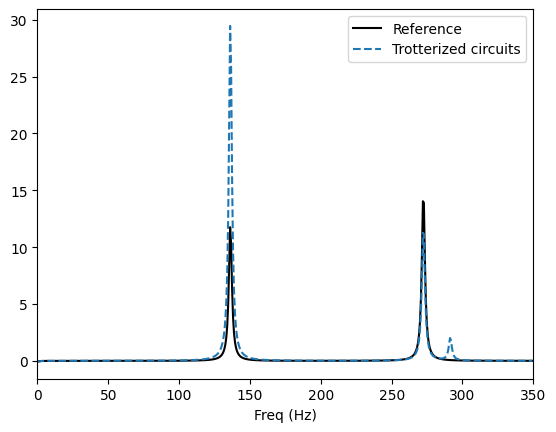

In [18]:
fid_apo = apodize_exp1d(FID-np.mean(FID), 12)
spec_apo = np.real(np.fft.fftshift(np.fft.fft(fid_apo)))

fid_apo_b = apodize_exp1d(FID_brute-np.mean(FID_brute), 12)
spec_apo_b = np.real(np.fft.fftshift(np.fft.fft(fid_apo_b)))
fig, ax = plt.subplots()
ax.plot(fgrid, spec_apo_b, 'k-',label='Reference')
ax.plot(fgrid, spec_apo,'--',label='Trotterized circuits')
ax.set_xlabel('Freq (Hz)')
ax.set_xlim([0, 350])


ax.legend()


Breaking the permutational symmetry of the Hamiltonian breaks down the validity of this approximation. To see this, we compute the low-field spectrum for the Hamiltonian 
$$ \hat{H} = J \mathbf{S}_{3}\cdot\left(\lambda\mathbf{S}_{2}+\mathbf{S}_{1}+\mathbf{S}_{0}\right)$$
for $\lambda\neq 1$, which can be conveniently obtained (alongside the exact spectrum obtained without Trotterization) through the *get_spectrum_from_ham* function:

In [7]:
#NOTICE: due to the number of points in the time grid (tgrid variable), this calculation takes ~15 min to complete
test_spec, test_exact = get_spectrum_from_ham(h_list, J_coup_grap,tgrid,bin_encs,m_vals,Sz_mat,lamb=0.1,nqubs=4,return_exact=True)

Target Hamiltonian: 213.94245970946488 [X0 X3] +
213.94245970946488 [Y0 Y3] +
213.94245970946488 [Z0 Z3] +
213.94245970946488 [X1 X3] +
213.94245970946488 [Y1 Y3] +
213.94245970946488 [Z1 Z3] +
21.39424597094649 [X2 X3] +
21.39424597094649 [Y2 Y3] +
21.39424597094649 [Z2 Z3]


/Users/luismartinezmartinez/Documents/QuEra/GitProjs/testing2/nmr-qsim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


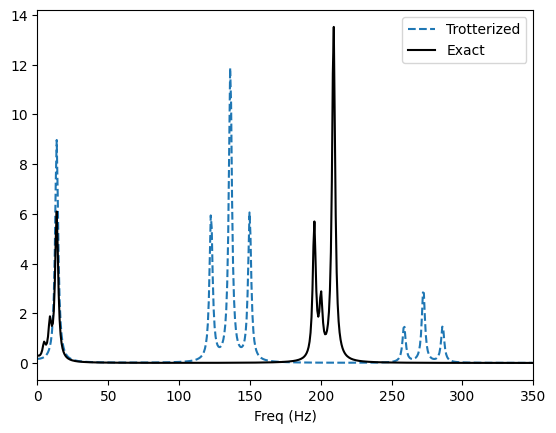

In [8]:
fig, ax = plt.subplots()
ax.plot(fgrid, test_spec,'--',label='Trotterized')
ax.plot(fgrid,test_exact,'k-',label='Exact')
ax.set_xlabel('Freq (Hz)')
ax.set_xlim([0, 350])
ax.legend()

# Toy models for near-term deployment in Hardware

The following toy models can be viewed as starting point systems, of increasing complexity, to simulate in hardware. We start with low-dimensional Heisenberg Hamiltonians and increase connectivity between spins. Interesting questions to address are: 1) what are the largest systems that we can deploy for the purposes of spectrally resolve a NMR FID? 2) To what extent can we "fit" spin connectivity featured in real molecules to those that can be efficiently implemented in hardware?
The first question implies more in-detail questions such as the realistic number of Trotter steps we can implement (which depends on strategies to reduce Trotter error, trade-off circuit depth by sampling complexity, etc.)

We can expect circuit compression to play an important role to maximize the space-time complexity that we can deploy in hardware. For the systems below, it would be great to get a sense on the maximal number of Trotter steps (at first within a noiseless asumption) for a target error $\epsilon$ in the estimation of total magnetization $\sum_{n}S^{z}_{n}$ for number of spins that go from 4 up to 20, and to what extent these circuits can be compressed. In practice, what really matters is to reproduce spectral resonances with a resolution comparable to experiments, we expect to have some freedom to increase Trotter step beyond these estimations for this target. 


### One dimensional chain. Periodic boundary conditions

In [9]:
def get_circular_couplings(N, Jvals):
    coup_list = []
    for i in range(N):
        coup_list.append( (i, (i+1)%N, Jvals[i]) )
    return coup_list

In [10]:
#A simple example of circuit
Nspins = 4 #we can try with number of spins [4,6,8,...,20] or a subset in this range

Jcoups = [2.0]*Nspins # we consider uniform couplings for simplicity

coup_graph = get_circular_couplings(Nspins, Jcoups)

h_list = [0.0]*Nspins # we assume low-field conditions with negligible Zeeman terms

ham_1D = generate_heisenberg_hamiltonian(h_list,coup_graph)

qub_reg = cirq.LineQubit.range(of.count_qubits(ham_1D))

compile_group(qub_reg,ham_1D*0.1) #trotter step of 0.1



0: ───PhXZ(a=0,x=0.5,z=1.11e-16)───@───PhXZ(a=-0.315,x=-0.5,z=0)──────────@───PhXZ(a=0.217,x=-0.5,z=0)───@───PhXZ(a=0.217,x=0.315,z=-0.717)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhXZ(a=-0.073,x=-0.438,z=0)──────@───PhXZ(a=-0.307,x=0.5,z=0)──────@───PhXZ(a=0.224,x=0.5,z=0)───────────────@───PhXZ(a=-0.876,x=0.257,z=-0.758)───
                                   │                                      │                              │                                                                                                                                                                                                                                                              │                                 │                                         │
1: ───PhXZ(a=0.5,x=-0.685,z=0)─────@───PhXZ(a=0.5,x=-0.968,z=-2.22e-16)───@───PhXZ(a=0.5,x=-0.968,z=0)───@───PhXZ(a=0.836,x=0.749,z=-0.129)───@───PhXZ(a=-0.0334,x=0.5,z=1.11e-16)───@───PhXZ(a=0.498,x=0.5,z=0)──────@───PhXZ(a=0.0726,x=0.379,z=0.306)────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┼─────────────────────────────────────────┼─────────────────────────────────────
                                                                                                                                              │                                      │                                │                                                                                                                                                 │                                 │                                         │
2: ──────────────────────────────────────────────────────────────────────────────────────────────────────────PhXZ(a=-0.149,x=-0.431,z=0)──────@───PhXZ(a=0.475,x=-0.968,z=0)─────────@───PhXZ(a=0.475,x=-0.968,z=0)───@───PhXZ(a=0.475,x=0.5,z=-0.508)─────@───PhXZ(a=-0.0334,x=0.5,z=1.11e-16)───@───PhXZ(a=0.498,x=0.5,z=0)──────@───PhXZ(a=0.0726,x=0.379,z=0.306)───┼─────────────────────────────────┼─────────────────────────────────────────┼─────────────────────────────────────
                                                                                                                                                                                                                                                           │                                      │                                │                                    │                                 │                                         │
3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhXZ(a=-0.149,x=-0.431,z=0)──────@───PhXZ(a=0.475,x=-0.968,z=0)─────────@───PhXZ(a=0.475,x=-0.968,z=0)───@───PhXZ(a=-0.388,x=0.659,z=0.43)────@───PhXZ(a=-0.416,x=-0.968,z=0)───@───PhXZ(a=-0.416,x=-0.968,z=-4.44e-16)───@───PhXZ(a=0.985,x=0.741,z=-0.479)────

### 2D lattice. Nearest neighbor couplings 

In [11]:
def square_lattice_couplings(N: int, J: float = 1.0) -> np.ndarray:
    """
    Generate nearest-neighbor couplings (i, j, J_ij) for a square lattice of size N x N.

    Args:
        N (int): Lattice linear size.
        J (float): Coupling constant (default 1.0).

    Returns:
        np.ndarray: Array of tuples (i, j, J_ij), where
                    i and j are integer spin indices (0-based),
                    and J_ij is the coupling between spins i and j.
    """
    couplings = []

    for r in range(N):
        for c in range(N):
            i = r * N + c  # site index

            # Right neighbor (same row, next column)
            if c + 1 < N:
                j = r * N + (c + 1)
                couplings.append((i, j, J))

            # Down neighbor (next row, same column)
            if r + 1 < N:
                j = (r + 1) * N + c
                couplings.append((i, j, J))

    return np.array(couplings, dtype=[('i', int), ('j', int), ('J_ij', float)])

In [12]:
# 3 x 3 example
sp_coup_graph = square_lattice_couplings(3, 2.0)

h_list = [0.0]*Nspins # we assume low-field conditions with negligible Zeeman terms

ham_sq = generate_heisenberg_hamiltonian(h_list,sp_coup_graph)

qub_reg = cirq.LineQubit.range(of.count_qubits(ham_sq))
compile_group(qub_reg,ham_sq*0.1) #trotter step of 0.1



0: ───PhXZ(a=-0.118,x=-0.204,z=0)───@───PhXZ(a=-0.302,x=0.5,z=0)──────────────@───PhXZ(a=0.229,x=0.5,z=5.55e-17)───@───PhXZ(a=-0.467,x=0.746,z=0.807)───@───PhXZ(a=-0.0334,x=0.5,z=1.11e-16)───@───PhXZ(a=0.498,x=0.5,z=0)──────@───PhXZ(a=0.0726,x=0.379,z=0.306)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    │                                         │                                    │                                    │                                      │                                │
1: ───PhXZ(a=-0.336,x=-0.667,z=0)───@───PhXZ(a=0.0406,x=-0.968,z=-4.44e-16)───@───PhXZ(a=0.0406,x=-0.968,z=0)──────@───PhXZ(a=0.434,x=0.229,z=-0.709)───┼──────────────────────────────────────┼────────────────────────────────┼───PhXZ(a=0.5,x=0.675,z=0)──────────@───PhXZ(a=-0.161,x=-0.5,z=0)────@───PhXZ(a=0.37,x=-0.5,z=0)──────@───PhXZ(a=-0.192,x=0.371,z=0.911)────@───PhXZ(a=-0.0334,x=0.5,z=1.11e-16)───@───PhXZ(a=0.498,x=0.5,z=0)──────@───PhXZ(a=0.0726,x=0.379,z=0.306)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                        │                                      │                                │                                    │                                │                                │                                     │                                      │                                │
2: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────┼────────────────────────────────┼───PhXZ(a=0.141,x=0.581,z=0)────────@───PhXZ(a=0.484,x=-0.968,z=0)───@───PhXZ(a=0.484,x=-0.968,z=0)───@───PhXZ(a=-0.821,x=0.364,z=-0.089)───┼──────────────────────────────────────┼────────────────────────────────┼───PhXZ(a=-0.383,x=0.42,z=0)────────@───PhXZ(a=-0.0334,x=0.5,z=1.11e-16)───@───PhXZ(a=0.498,x=0.5,z=0)──────@───PhXZ(a=0.0726,x=0.379,z=0.306)───────────────────────────

# A more biologically relevant target molecule

In [13]:
from ham_comp_utils import parse_gaussian_jmatrix,connect_map_from_jmat
from IPython.display import Image, display

Fluorinated tags as used in this [paper](https://doi.org/10.1038/s41557-025-01818-8), and will be the target for hardware explorations. As of now, we dont have the Heisenberg couplings for the fluorinated molecules (but can nonetheless be reprduced from DFT calculations). We have instead, J couplings for a related non-fluorinated aromatic molecule:


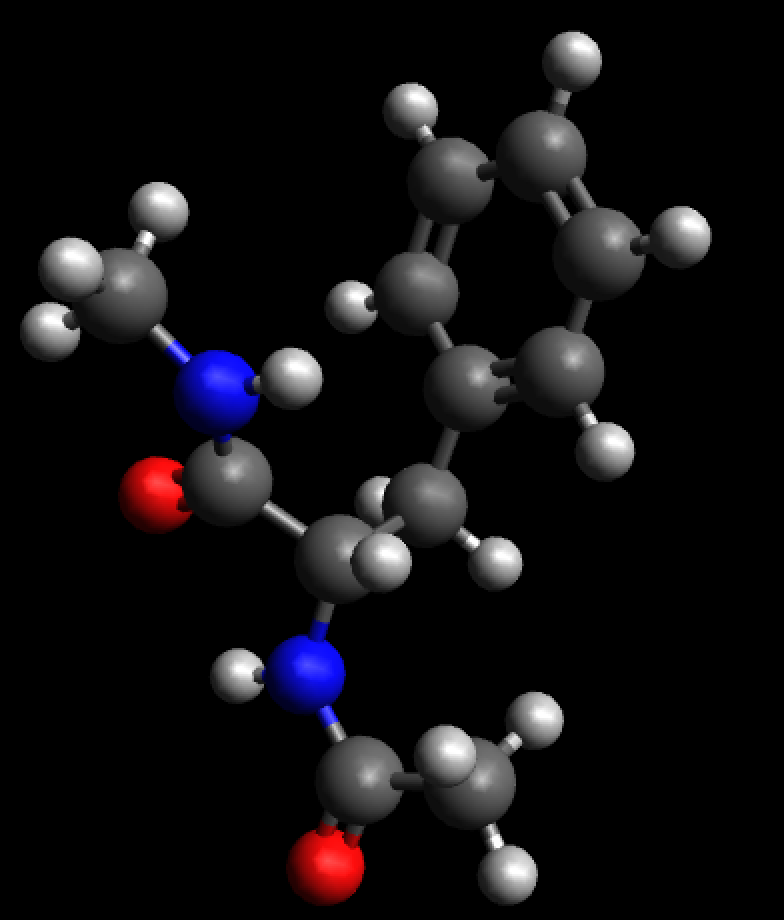

In [14]:
display(Image(filename='../figures/nonF_mol.png',width=400))

J couplings can be parsed from the Gaussian log file as shown below. In practice, only a subset of nuclei would be relevant for the NMR protocol, which for this particular case correspond to nuclei that constitute the aromatic ring and nearby ones. For simplicity, we exclude the amide groups:

In [15]:
jmat = parse_gaussian_jmatrix('../data/trosy_uncoupled/phe.log')

#jamt[30,27] corresponds to a J coupling between a couple of hydrogen neighbors in the aromatic ring, we see an agreement with the expected 10 Hz

tar_nuc_idxs = np.array([17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]) -1 #these are the atom indices that exclude the amide groups of the molecule
                                                                              #the 31 label corresponds to the hydrogen that is substituted with F in the fluorinated tag

##we artificially remove the target hydrogen with F by substituting the correspong coupling in the J coupling matrix by experimental value
jmat[28,31] = 240
jmat[31,28] = 240


mol_Jcoup_graph = connect_map_from_jmat(jmat,tar_nuc_idxs)
#Notice that we must post-process this graph when considering isotopes different from the most abundant ones.

#in a low-field experiment...
mol_hs = np.zeros(len(tar_nuc_idxs))

mol_hamiltonian = generate_heisenberg_hamiltonian(mol_hs, mol_Jcoup_graph)




In [16]:
test_time = 0.1
tar_mol_ham = test_time*mol_hamiltonian

qub_reg_mol = cirq.LineQubit.range(len(tar_nuc_idxs))

mol_circ = compile_group(qub_reg_mol,tar_mol_ham)

Something important to note is that even though the J coupling connectivity between spins is amenable to clustering, thus effectively dealing with a collection of independent systems that can be trivially simulated, we expect a less trivial connectivity when adding correlated dissipation channels. The exact form of these channels as well as the definition of the subset of spins that are relevant for the target NMR protocol is work in progress. In the meantime, cicuit compression of this circuit can be useful for compilation of open dynamics 

## Noisy simulation.

We can easily incorporate [QuEra's noise model](https://bloqade.quera.com/dev/digital/examples/interop/noisy_ghz/) in the low-field NMR simulation, which is wrapped-up in the *get_spectrum_from_ham* function as shown below. Under the hood, the compiled circuits are annotated with Pauli noise channels (see [here](https://bloqade.quera.com/dev/blog/2025/07/30/simulating-noisy-circuits-for-near-term-quantum-hardware/#ghz-data) for a more detailed description of the model) and simulated at the density matrix level.

In [17]:
#NOTICE: due to the number of points in the time grid (tgrid variable), this calculation takes ~25 min to complete
noise_model = noise.GeminiOneZoneNoiseModel()
noisy_spec, exact_spec = get_spectrum_from_ham(h_list, J_coup_grap,tgrid,bin_encs,m_vals,Sz_mat,lamb=1.0,nqubs=4,return_exact=True,noise_model=noise_model)


Target Hamiltonian: 213.94245970946488 [X0 X3] +
213.94245970946488 [Y0 Y3] +
213.94245970946488 [Z0 Z3] +
213.94245970946488 [X1 X3] +
213.94245970946488 [Y1 Y3] +
213.94245970946488 [Z1 Z3] +
213.94245970946488 [X2 X3] +
213.94245970946488 [Y2 Y3] +
213.94245970946488 [Z2 Z3]


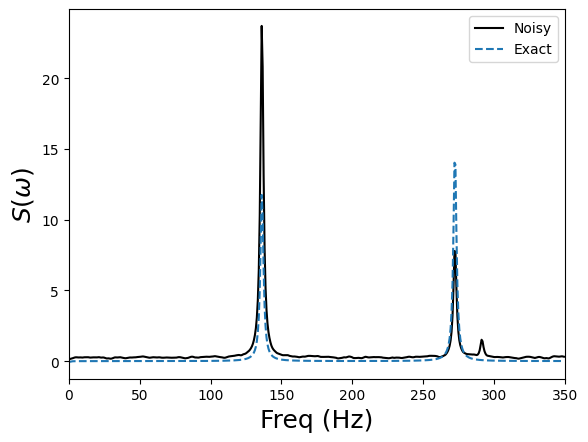

In [18]:
fig, ax = plt.subplots()

ax.plot(fgrid,noisy_spec,'k-',label='Noisy') 
ax.plot(fgrid,exact_spec,'--',label='Exact')


ax.set_xlabel('Freq (Hz)',fontsize=18)
ax.set_ylabel(r'$S(\omega)$',fontsize=18)
ax.set_xlim([0, 350])
ax.legend()


# Open Quantum System simulations

In [21]:
from ham_comp_utils import FirstOrderTrotterEvol, get_dil_Ham
from basis_utils import Sz
from direct_sim_utils import qutip_ref_sim, jump_sz_sz, time_trace_renormdm
from qutip import basis, tensor, qeye, sigmax
from scipy import sparse

For the purpose of illustrating the compilation of circuits for open quantum system dynamics, we consider the simple spin Hamiltonian
$$ \hat{H} =\sum^{2}_{i=0}S^{z}_{i} + 2\mathbf{S}_{0}\cdot \mathbf{S}_{1}+1.5\mathbf{S}_{1}\cdot\mathbf{S}_{2}$$

In [22]:
h_list = [1.0, 1.0, 1.0]  # h_i for qubits 0, 1, 2
coupling_graph = [
    (0, 1, 2.0),  # J_{0,1}
    (1, 2, 1.5),  # J_{1,2}
]

hamiltonian = generate_heisenberg_hamiltonian(h_list, coupling_graph)
print(hamiltonian)

0.5 [X0 X1] +
0.5 [Y0 Y1] +
0.5 [Z0] +
0.5 [Z0 Z1] +
0.375 [X1 X2] +
0.375 [Y1 Y2] +
0.5 [Z1] +
0.375 [Z1 Z2] +
0.5 [Z2]


As a simple example of an ancillary-based compilation of circuits, we have 

In [23]:

###Taking a look at a single Trotter step....
deltaT = 0.1
sys_qub_reg = cirq.LineQubit.range(3) #the system qubit register
anc_qub_reg = cirq.LineQubit.range(3,5) #the ancilla qubit register
kappa = 5.0

JumpOp = [np.sqrt(kappa)*Sz(0)*Sz(1), np.sqrt(kappa)*Sz(1)*Sz(2)]


dil_ham = get_dil_Ham(hamiltonian,deltaT,JumpOp) #The dilated Hamiltonian that generates the unitary evolution on the system+ancilla Hilbert space

test_Trotter = FirstOrderTrotterEvol(sys_qub_reg,anc_qub_reg, dil_ham,deltaT, n_steps=1) #n_steps is the number of Trotter steps


In [24]:
test_Trotter

0: ───Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────
                                                        │                │                           │                │              │                │                                                                                                                           │                        │
1: ────────────────Rz(0.032π)────────────────Ry(0.5π)───X───Rz(0.032π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.032π)───X───Rx(0.5π)───X───Rz(0.032π)───X───Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@──────────────X───@────────────────@───X──────────────────────────@────────────────────────@───────────────────
                                                                                                                                                                     │                │                           │                │              │                │                  │                │                              │                        │
2: ─────────────────────────────Rz(0.032π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───X───Rz(0.024π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.024π)───X───Rx(0.5π)───X───Rz(0.024π)───X──────────────────┼────────────────┼──────────────────────────────X───@────────────────@───X───────────────────
                                                                                                                                                                                                                                                                                      │                │                                  │                │
3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.113π)───X───────Ry(-0.5π)───R──────────────┼────────────────┼───────────────────────
                                                                                                                                                                                                                                                                                                                                          │                │
4: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.113π)───X───────Ry(-0.5π)───R───

To benchmark our compiled circuits, we regard QuTip simulations as our ground truth

In [25]:
nqubs = of.count_qubits(hamiltonian)

time = 10.0
t_steps = 500
deltaT= time/t_steps
kappa = 5.0
prop_steps = 100 ###number of steps to  simulate

L = np.sqrt(kappa)*jump_sz_sz(0, 1, nqubs) #jump operator \sqrt{\kappa}Sz_{0}Sz_{1}
L2 = np.sqrt(kappa)*jump_sz_sz(1,2,nqubs) #jump operator \sqrt{\kappa}Sz_{1}Sz_{2}
jump_ops = [L,L2]

local_sx = tensor([qeye(2),sigmax(),qeye(2)]) #We track the expectation value of Sx_{1}
e_ops = [local_sx]
psi0 = tensor([basis(2, 0), basis(2, 1), basis(2, 0)])+tensor([basis(2, 0), basis(2, 0), basis(2, 0)])
psi0 = (1.0/np.sqrt(2))*psi0

#we get the expectation value of Sx_{1} with and without dissipation
res_diss, res_clean = qutip_ref_sim(hamiltonian,psi0,deltaT,Nsteps=prop_steps,c_ops=jump_ops,e_ops=e_ops)


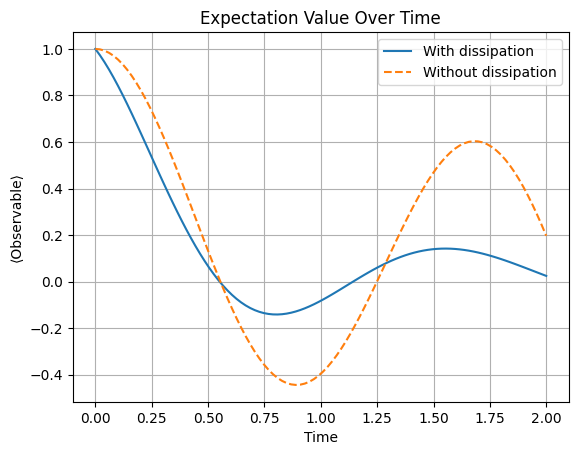

In [26]:
#Access times
times = res_diss.times  # Same as the times array you created

# Access expectation values (list of arrays: one per observable)
expect_diss = res_diss.expect[0]  # Only one observable here
expect_clean = res_clean.expect[0]

# Plotting
plt.plot(times, expect_diss, label="With dissipation")
plt.plot(times, expect_clean, label="Without dissipation", linestyle='--')
plt.xlabel("Time")
plt.ylabel("⟨Observable⟩")
plt.title("Expectation Value Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
#####We build the system qubit's by hand at the density matrix level
nqubs = of.count_qubits(hamiltonian)

JumpOp = [np.sqrt(kappa)*Sz(0)*Sz(1), np.sqrt(kappa)*Sz(1)*Sz(2)] #same jump operators as the QuTip simulation
psi0 = tensor([psi0]+[basis(2,0)]*len(jump_ops)) #the state vector |\psi_{0}\rangle \otimes |00\rangle, where the |00\rangle state lives in the space spanned by the two ancilla qubits


times_ = np.linspace(0,prop_steps*deltaT,prop_steps)


#This function simulates the open dynamics by constructing the Trotter circuits with the jump operator gadgets at the density matrix level and computing the expectation value of Sx_{1}.
#In practice, for sufficiently long times, the ensuing density matrix loses its positive character (under an stringent numerical tolerance imposed by the cirq simulator, which throws
# an error), in spite of the circuits encoding a formal positive mapping. We enforce the positive and trace preserving mapping during the simulation under a less stringent
# numerical threshold inside this function. 
pol_trace = time_trace_renormdm(hamiltonian,JumpOp,sparse.csr_matrix(local_sx.full()),prop_steps*deltaT,prop_steps,init_state=psi0.full())

/Users/luismartinezmartinez/Documents/QuEra/GitProjs/testing2/nmr-qsim/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/luismartinezmartinez/Documents/QuEra/GitProjs/testing2/nmr-qsim/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


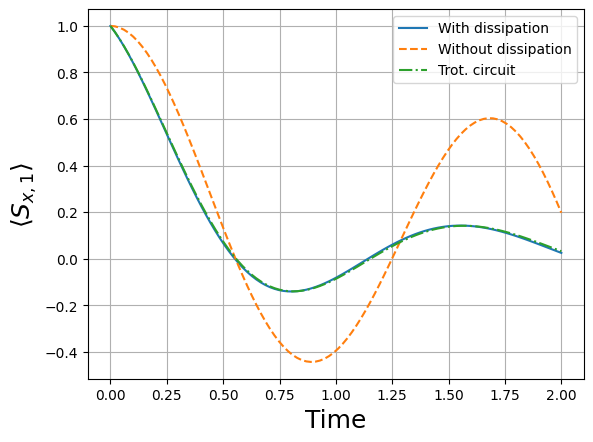

In [28]:
plt.plot(times, expect_diss, label="With dissipation")
plt.plot(times, expect_clean, label="Without dissipation", linestyle='--')
plt.plot(times_,pol_trace,label="Trot. circuit",linestyle='-.')
plt.xlabel("Time",fontsize=18)
plt.ylabel(r"$\langle S_{x,1}\rangle$",fontsize=18)
#plt.title("Expectation Value Over Time")
plt.legend()
plt.grid(True)
plt.show()
